# Implementation of H2PC structure learning algorithm for bayesian network
#### Author: Lorenzo Venturi

In this notebook it is presented, implemented and tested in python an hybrid algorithm for Bayesian network structure learning, called H2PC.

The idea comes from the paper: **Maxime Gasse, Alex Aussem, Haytham Elghazel, A hybrid algorithm for Bayesian network structure learning with application to multi-label learning** (https://arxiv.org/abs/1506.05692v1).

H2PC first reconstructs the skeleton of a Bayesian network and then performs a Bayesian-scoring greedy hill-climbing combined with Tabu search to orient the edges.

In [1]:
import utils
import pandas as pd
import pyAgrum as gum
import itertools
from sklearn.preprocessing import LabelEncoder
from pgmpy.models import BayesianNetwork
from collections import OrderedDict
from fractions import Fraction
import pickle
from pgmpy.readwrite import BIFReader
from pgmpy.estimators import MmhcEstimator
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import networkx as nx
import warnings
import logging
import tempfile
import time
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
logging.getLogger("pgmpy").setLevel(logging.ERROR)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## HPC

HPC algorithm's aim is to learn the parents and childrens of a target variable in a Bayesian Network, the algorithm combines ideas from incremental and divide-and-conquer constraint-based subroutines to learn the local structure around a target variable.

It is divided in 3 subroutines:
1. **DE_PCS** : Data-Efficient Parents and Children Superset
2. **DE_SPS** : Data-Efficient Spouses Superset
3. **FDR_IAPC** : Incremental Association Parents and Children with false discovery rate control

To well understand the code below it is necessary to understand these 5 concepts: 

- **Parents**: variables that influence our target

- **Childrens**: variables that directly are affected by our target

- **Markov Blanket**: is any set of variables such that (variable target) T is conditionally independent of all the remaining variables outside the Blanket given the blanket.

- **Markov Boundary**: minimum set of a Markov Blanket.

- **D-separation**: two variables X,Y are d-separated by a set of variables SET if  all paths from X to Y is blocked by SET. If they are d-separated given SET, they are conditional independent given SET.

In [2]:
class HPC():
    def __init__(self,target_node: str,learner:gum.BNLearner,
                 nodes_linked: list[tuple[str,str]]=[],nodes_not_linked:list[tuple[str,str]]=[],
                 good_nodes:set[str]=set(),bad_nodes:set[str]= set(),
                 threshold:float=0.05):
        
        self.target_node = target_node
        self.threshold = threshold
        self.good_nodes = good_nodes
        self.bad_nodes = bad_nodes
        self.learner = learner
        
        #we check if the nodes are linked or not to our target by previous computations in the H2PC algorithm
        self.nodes_linked={
            node for arc in nodes_linked if ( node:=utils.connected_node(arc,target_node) ) is not None
        }
        self.nodes_not_linked={
            node for arc in nodes_not_linked if ( node:=utils.connected_node(arc,target_node) ) is not None
        }
        self.dataset_variables=set(self.learner.names())
    
    def DE_PCS(self)-> tuple[set[str],dict[str,set[str]],OrderedDict[str,float]]:
        """
        Data-Efficient Parents and Children Superset(DE-PCS)
        It search a superset of PC_T with a severe restriction on the maximum conditioning size |Z|<=1.
        (Test only direct independence between T and X, and an indirect independence between T and X given Z)
        Returns:
        - possibleParents: the set of nodes that are possible parents of the target node
        - d_separated: a dictionary where the keys are nodes and the values are sets of nodes that d-separate them from the target node
        - p_values: an ordered dictionary of  p-values for the nodes in possibleParents, sorted in descending order
        """
        possibleParents=self.dataset_variables.difference({self.target_node},self.nodes_not_linked)
        nodes_to_check = possibleParents.difference(self.good_nodes.union(self.nodes_linked))
        p_values=OrderedDict()
        d_separated={}
        
        for x in nodes_to_check:
            _,pvalue=self.learner.chi2(self.target_node,x)
            if pvalue>self.threshold:
                if x in possibleParents:
                    possibleParents.remove(x)
                d_separated[x] = set()
            else:
                p_values[x]=pvalue
        for bad_node in self.nodes_not_linked:
            d_separated[bad_node]=set()

        p_values = OrderedDict( sorted(p_values.items() , key=lambda item:item[1],reverse=True))
        p_values.update({node:0.0 for node in self.nodes_linked.union(self.good_nodes)})
        for x in p_values.keys():
            new_p_values = OrderedDict((k, v) for k, v in sorted(p_values.items(), key=lambda  x:x[1] ) if k != x)
            for key in new_p_values.keys():
                _,pvalue=self.learner.chi2(self.target_node,x,[key])
                if pvalue>self.threshold:
                    possibleParents.remove(x)
                    d_separated[x]={key}
                    break
                else:
                    if pvalue>p_values[x]:
                        p_values[x]=pvalue
        return possibleParents,d_separated,p_values
               
    def DE_SPS(self, possibleParents:set[str], d_separated:dict[str,set[str]])-> set[str]:
        """
        Data-Efficient Spouses Superset(DE-SPS)
        It search a superset of SP_T(spouses(nodes that shares a common child)) with a severe restriction on the maximum conditioning size |Z|<=2.
        ex.
        Z=0->   T->X<-Y (test if T and Y are d-separated given nothing)
        Z=1->   T->X<-Y (test if T and Y are d-separated given X)
        Z=2->   T->X<-Y<-Z (test if T and Y are d-separated given X and Z)
        Returns:
        - spouses: a set of nodes that are possible spouses of the target node
        """
        spouses = set()
        for x in possibleParents:
            spousesX = set()
            p_values_x = {}
            nodes_to_check = self.dataset_variables.difference({self.target_node}.union(possibleParents))
            for node in nodes_to_check:
                if node not in d_separated:
                    d_separated[node] = set()
                if x in d_separated[node]:
                    continue
                condition = list(d_separated[node] - {self.target_node})
                
                _,pvalue = self.learner.chi2(self.target_node,x,condition)
               
                if pvalue < self.threshold:
                    spousesX.add(node)
                    p_values_x[node] = pvalue
            
            p_values_x_ord = OrderedDict(sorted(p_values_x.items(), key=lambda x: x[1], reverse=True))

            #We remove spouses that are low correlated with the target given an additional variable(T->X<-Z<-...<-Y)
            for spouse in p_values_x_ord.keys():
                p_values_x_ord_1 = OrderedDict(p_values_x_ord)
                p_values_x_ord_1.pop(spouse)
                for z in p_values_x_ord_1:
                    condition = list({x}.union({z}))
                    stat, pvalue = self.learner.chi2(self.target_node, spouse, condition)
                    if pvalue > self.threshold:
                        spousesX.remove(spouse)
                        break
            spouses.update(spousesX)
        return spouses
    
    def FDR_IAMB(self,target:str,neighborhood:set[str])-> set[str]:
        """
        Incremental Association Parents and Children with False Discovery Rate control
        It refines the learned Markov Blanket:
         (set of children, parents, spouses of the node that makes the target independent from the rest) using a False Discovery Rate control method.
        It first applies an indendence test to check if the node is independent from the target node given the other nodes of the MB.
        It secondly checks whether nodes in the neighborhood (but not currently in the Markov Boundary)
          are conditionally dependent on the target node (target) given the current Markov Boundary.
        Returns:
        - markov_Boundary: the correct MB of the target node
        """
        markov_Boundary=self.nodes_linked.union(self.good_nodes)
        mb_history=[]
        p_values={}
        culprit_nodes=set()
        i=0
        harmonic_sum = Fraction()
        for i in range(1, len(neighborhood)):
            harmonic_sum += Fraction(1 / i)
        index_sum= float(harmonic_sum*len(neighborhood))

        while i<len(neighborhood)*80:
            previous_exclusion = False
            change_made = False
            for node in neighborhood:
                condition=markov_Boundary.difference({node})
                _,p_value=self.learner.chi2(target,node,list(condition))
                p_values[node]=p_value        
            p_values=OrderedDict(sorted(p_values.items(), key=lambda x: x[1]))
            for (index,sorted_neighbour) in enumerate(p_values.keys()):
                candidates_to_remove=markov_Boundary.difference(self.good_nodes,self.nodes_linked)
                if sorted_neighbour in candidates_to_remove:
                    adjusted_pvalue=(p_values[sorted_neighbour]*index_sum)/(index+1)
                    if adjusted_pvalue>self.threshold:
                        current_excluded_node=sorted_neighbour
                        current_included_node=None
                        markov_Boundary=markov_Boundary.difference({sorted_neighbour})
                        previous_exclusion=True
                        change_made=True                     
                        break
            if not previous_exclusion:
                for (index, sorted_neighbour) in enumerate(p_values.keys()):
                    possible_parents=neighborhood.difference(markov_Boundary.union(culprit_nodes,self.bad_nodes))
                    if sorted_neighbour in possible_parents:
                        adjusted_pvalue=(p_values[sorted_neighbour]*len(neighborhood))/(index+1)
                        if adjusted_pvalue<self.threshold:
                            current_included_node=sorted_neighbour
                            current_excluded_node=None
                            markov_Boundary=markov_Boundary.union({sorted_neighbour})
                            change_made=True
                            break

            if not change_made:
                break

            if markov_Boundary in mb_history:
                mb_history.pop()
                i -= 1
                culprit_nodes.add(current_excluded_node)
                culprit_nodes.add(current_included_node)  
                mb_history.append(markov_Boundary)     
            i+=1
        return markov_Boundary
    
    def FDR_IAPC(self, neighborhood: set[str], target_node: str) -> set[str]:
        """
        FDR-IAPC removes the spouses SP_T from the estimated Markov boundary MBT output by IAMBFDR,
          and returns PC_T.
        Returns:
        -filtered markov boundary: an estimation of PC_T
        """
        initial_markov_boundary = self.FDR_IAMB(target_node, neighborhood) 
        filtered_markov_boundary = set()
        for node in initial_markov_boundary:
            
            if self.D_separation(target_node, node, initial_markov_boundary):
                filtered_markov_boundary.add(node)
        
        return filtered_markov_boundary

    def Hybrid_HPC(self):
        """
        It applies:
        - DE-PCS: to find a superset of parents and children of the target node.
        - DE-SPS: to find a superset of spouses of the target node.
        - FDR-IAPC: to find the parents and children of the target node.
        Returns:
        - markov_blanket: a dictionary containing the parents and children of the target node found by the algorithm
        """
        markov_blanket={"parents_children":set()}
        PCS,d_separation,_=self.DE_PCS()
        if(len(PCS) < 2):
            markov_blanket["parents_children"]=PCS                             
            return(markov_blanket["parents_children"])

        SPS=self.DE_SPS(PCS,d_separation)
        combined_neighborhood=PCS.union(SPS).copy()
        
        if len(combined_neighborhood)<3:
            markov_blanket["parents_children"]=PCS                             
            return(markov_blanket["parents_children"])
        
        PC=self.FDR_IAPC(combined_neighborhood,self.target_node)

        for par_child in PCS.difference(PC):
            neighborhood_for_candidate=combined_neighborhood.union({self.target_node}).difference({par_child}) 
            if self.target_node in self.FDR_IAPC(neighborhood_for_candidate,par_child):
                PC=PC.union({par_child})    
                
        """ markov_blanket["parents_children"]=PC         
        markov_blanket["spouses"]=SPS """
        return(PC)      
     
    def D_separation(self, target:str, candidate_node:str, conditioning_set:set[str]) -> bool:
        elements = list(conditioning_set.difference({candidate_node}))
        all_condition_combinations = list(itertools.chain.from_iterable(
            itertools.combinations(elements, r) for r in range(len(elements) + 1)
        ))
        for condition_subset in all_condition_combinations:
            _, p_value = self.learner.chi2(target, candidate_node, condition_subset)
            if p_value >= self.threshold:
                return False
        return True


## H2PC ALGORITHM
H2PC is a **structure learning algorithm**: a class of methods that try to learn in the best possible way the structure of a Bayesian network starting from the data.

It is based on 2 key phases:

1. **CB** (constraint-based) subroutine: **HPC** 
    
2. **SS** (search and score) subroutine: **greedy Hill Climbing extended with Tabu search**.
    - Applies greedy Hill Climbing (constrained on the edges discovered by HPC): it starts with an empty graph, the edge addition, deletion, or direction reversal that leads to the largest increase in score (BDeu) is taken and the search continues recursively. 
    
    - The search is extended with a TABU list that keeps track of the last 100 structures explored. Instead of applying the best local change, the best local change that results in a structure not on the list is performedin an attempt to escape local maxima. When 15 changes occur without an increase in the maximum score ever encountered during search, the algorithm terminates.
    
    - The over all best scoring structure is then returned.

In [3]:
class H2PC:
    def __init__(self, dataFrame:pd.DataFrame, threshold:float, learner:gum.BNLearner):
        self.threshold = threshold
        self.learner = learner
        self.dataFrame = dataFrame
        self.nodes_not_linked = set()
        self.nodes_linked = set()
        self.variables = list(dataFrame.columns)

    def check_consistency(self, dictionnary_neighbourhood: dict) -> dict:
        """
        Check the consistency of the dictionary by applying mutual inclusion ( X is neighbour of Y if and only if Y is neighbour of X).
        It removes the inconsistent edges from the dictionary.
        Returns:
        - consistent_dictionnary_neighbourhood: a dictionary where the keys are the variables and the values are the neighbours
        """
        consistent_dictionnary_neighbourhood = {k: set() for k in self.variables}
        for X, Y in itertools.combinations(dictionnary_neighbourhood.keys(), 2):
            PC_X = dictionnary_neighbourhood[X].copy()
            PC_Y = dictionnary_neighbourhood[Y].copy()
            if (X in PC_Y) and (Y in PC_X):
                consistent_dictionnary_neighbourhood[X].add(Y)
                consistent_dictionnary_neighbourhood[Y].add(X)
        return consistent_dictionnary_neighbourhood

    def _unique_edges(self, consistent_dictionnary: dict) -> set:
        """
        It checks if the edges are unique in the dictionary.
        Returns:
        - unique_edges: the set of unique edges in the dictionary
        """
        unique_edges = {(variable, neighbour) for variable, neighbours in consistent_dictionnary.items() for neighbour in neighbours}
        return unique_edges
    
    def _add_set_unique_possible_edges(self, unique_possible_edges: set):
        for unique_edge in unique_possible_edges:
            self.learner.addPossibleEdge(*unique_edge)

    def _learn_graphical_structure(self):
        """
        It first learns the structure using the greedy hill climbing algorithm, then refines it using local search with a tabu list,
         tabu_size=100 and nb_decrease=15.
        Returns:
        - refined_bn: the refined Bayesian network structure
        """
        tabu_size = 100  
        nb_decrease = 15
        self.learner.useGreedyHillClimbing()
        learned_bn = self.learner.learnBN()
        dag=learned_bn.dag()
        self.learner.setInitialDAG(dag)
        self.learner.useLocalSearchWithTabuList(tabu_size=tabu_size, nb_decrease=nb_decrease)
        refined_bn = self.learner.learnBN()
        return refined_bn

    
    def HPC_skeleton(self):
        """
        It applies the Hybrid HPC algorithm to each variable in the dataset.
        """   
        dico_couverture_markov = {}
        for target in self.variables:
            dico_couverture_markov[target] = HPC(
                target,
                learner=self.learner,
                nodes_linked=self.nodes_linked,
                nodes_not_linked=self.nodes_not_linked,
                threshold=self.threshold
            ).Hybrid_HPC()
            
        return dico_couverture_markov

    def learnBN(self):
        """
        It learns the Bayesian network structure using the H2PC algorithm.
        1. Applies HPC
        2. Applies GreedyHillClimbing combined with tabu list
        """
        dico_couverture_markov = self.HPC_skeleton()
        self.consistent_neighbourhood = self.check_consistency(dico_couverture_markov)

        try:
            with open('dictionnary', 'wb') as fichier:
                pickle.dump(self.consistent_neighbourhood, fichier)
        except Exception as e:
            print(f"Error saving dictionary: {e}")

        try:
            with open('dictionnary', 'rb') as fichier:
                dico_couverture_markov = pickle.load(fichier)
        except Exception as e:
            print(f"Error loading dictionary: {e}")

        unique_possible_edges = self._unique_edges(self.consistent_neighbourhood)
        
        self._add_set_unique_possible_edges(unique_possible_edges)
        return self._learn_graphical_structure()

## Test the algorithm

In order to evaluate the perfomance of the algorithm implemented, we compare it with the algorithm MMHC (Max Min Hill Climbing) similarly to what discussed in the paper, in particular i take in consideration these metrics with the aim to face all the aspects of a BN:  
- Structure metrics (based exclusively on the skeleton of the network) (basically we are evaluating HPC(of H2PC) vs Max-Min Parents and Children (of MMHC) Phase)
    - False positive edge ratio
    - Structure Precision: the number of true positive edges in the output divided by the number of edges in the output
    - Structure Recall: the number of true positive edges divided by the true number of edges
- Performance indicators:
    - SHD: structural hamming distance
    - BIC SCORE: measure of goodness of the fit
    - Computational time complexity

We will use 3 different datasets taken from the bnlearn repository, with a number of nodes and dependencies increasingly more challenging:
- asia dataset: 8 nodes
- sachs dataset: 11 nodes
- alarm dataset: 37 nodes.

Each test will be executed on different sizes of the dataset in input to evaluate model generalization ability. 


In [14]:
def build_models(df,sizes):
    models_MMHC=[]
    models_H2PC=[]
    times_MMHC=[]
    times_H2PC=[]
    random_state = 42
    
    for size in sizes:

        subset = df.sample(size, random_state=random_state)
        #train_data,test_data=train_test_split(subset, train_size=0.8,random_state=random_state)
        # MMHC ALGORITHM DEFINITION
        start_time_mmhc = time.time()
        MMHC = MmhcEstimator(subset)
        MMHC_model = MMHC.estimate()
        model_MMHC = BayesianNetwork()
        all_nodes_MMHC = subset.columns.tolist()
        model_MMHC.add_nodes_from(all_nodes_MMHC)
        for edge in MMHC_model.edges():   
            if not nx.has_path(model_MMHC, edge[1], edge[0]):  
                model_MMHC.add_edge(edge[0], edge[1])
        end_time_mmhc=time.time()
        # H2PC ALGORITHM DEFINITION
        with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as temp_file:
            subset.to_csv(temp_file.name, index=False)
            start_time_h2pc = time.time()
            learner = gum.BNLearner(temp_file.name)  # Use the temporary file path
            h2pc = H2PC(dataFrame=subset, threshold=0.05, learner=learner)
            bn_H2PC = h2pc.learnBN()
            end_time_h2pc = time.time()
            model_h2pc = utils.convertBN_pyAgrum_Pgmpy(bn_H2PC)

        models_MMHC.append(model_MMHC)
        models_H2PC.append(model_h2pc)   
        times_MMHC.append(end_time_mmhc-start_time_mmhc)
        times_H2PC.append(end_time_h2pc-start_time_h2pc)
        

    return models_MMHC,models_H2PC,times_MMHC,times_H2PC

def evaluate_Models(models_MMHC,models_H2PC,times_MMHC,times_H2PC,test_data,sizes,true_model_bif):
        metrics = {
            "MMHC": {
                "False_Positive_edge_ratios": [],
                "precisions": [],
                "recalls": [],
                "shd": [],
                "bic_scores": [],
                "execution_times": []
            },
            "H2PC": {
                "False_Positive_edge_ratios": [],
                "precisions": [],
                "recalls": [],
                "shd": [],
                "bic_scores": [],
                "execution_times": []
            }
        }

        reader = BIFReader(true_model_bif)
        true_model = reader.get_model()

        for i in range(len(models_H2PC)):
            model_MMHC = models_MMHC[i]
            model_H2PC = models_H2PC[i]
            
            metrics_MMHC=utils.calculate_metrics(model_MMHC, true_model,times_MMHC[i],test_data)
            metrics_H2PC=utils.calculate_metrics(model_H2PC, true_model,times_H2PC[i],test_data)
             
            metrics["MMHC"]["False_Positive_edge_ratios"].append(metrics_MMHC["false_positive_edge_ratio"])
            metrics["MMHC"]["precisions"].append(metrics_MMHC["precision"])
            metrics["MMHC"]["recalls"].append(metrics_MMHC["recall"])
            metrics["MMHC"]["shd"].append(metrics_MMHC["shd"])
            metrics["MMHC"]["bic_scores"].append(metrics_MMHC["bic-score"])
            metrics["MMHC"]["execution_times"].append(times_MMHC[i])

            metrics["H2PC"]["False_Positive_edge_ratios"].append(metrics_H2PC["false_positive_edge_ratio"])
            metrics["H2PC"]["precisions"].append(metrics_H2PC["precision"])
            metrics["H2PC"]["recalls"].append(metrics_H2PC["recall"])
            metrics["H2PC"]["shd"].append(metrics_H2PC["shd"])
            metrics["H2PC"]["bic_scores"].append(metrics_H2PC["bic-score"])
            metrics["H2PC"]["execution_times"].append(times_H2PC[i])
        

        utils.plot_metrics(metrics,sizes) #train data are 4 times the test data (20% to 80%)
        return metrics,true_model
 

## 1.Test on Asia Dataset

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

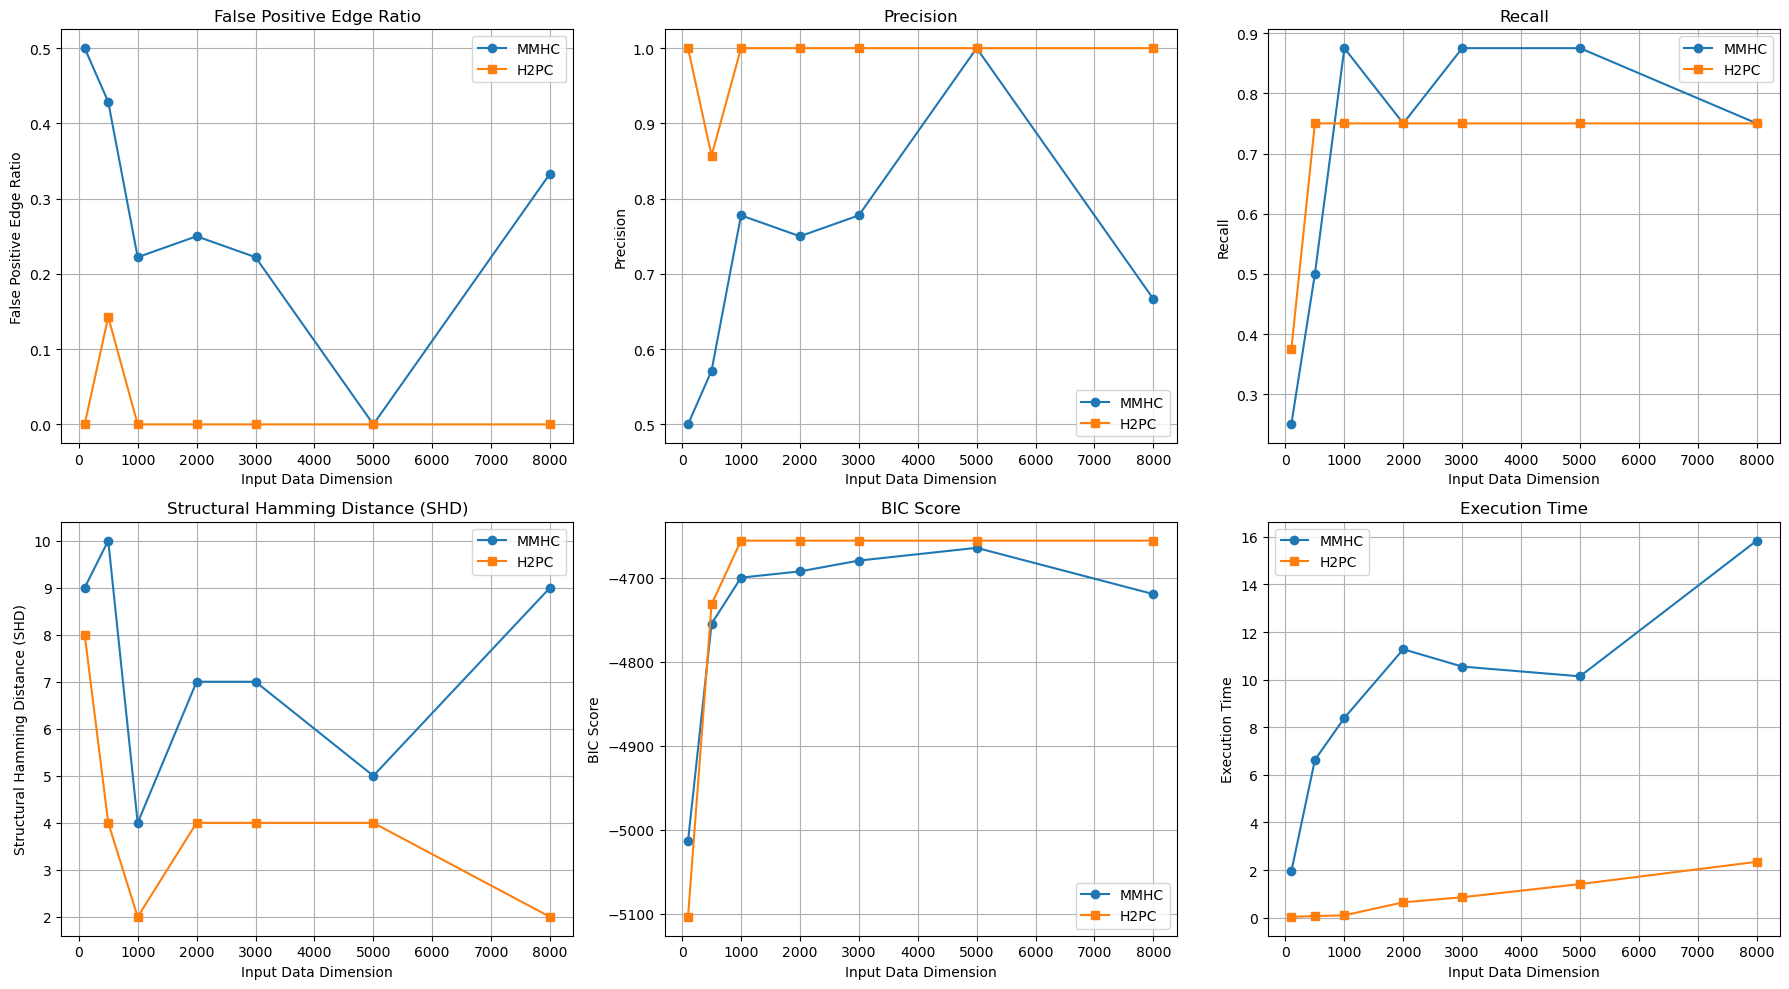

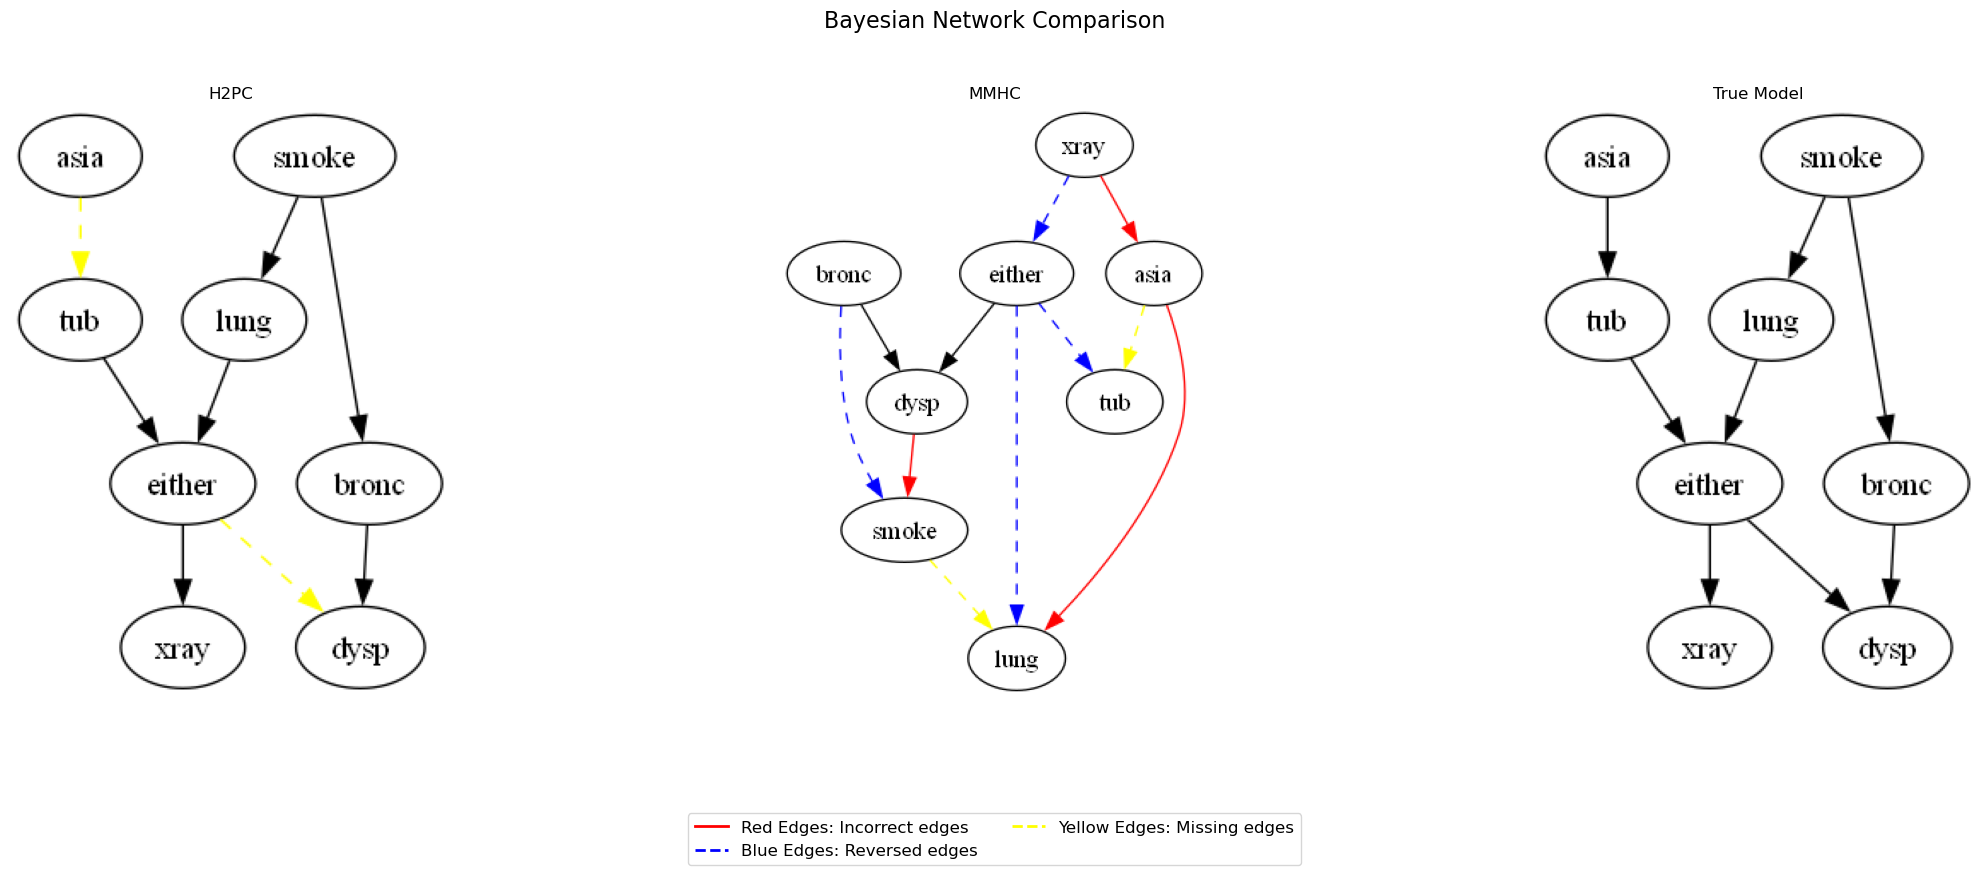

In [5]:
df = pd.read_csv("Datasets/asia.csv")
df = df.replace({'yes': 1, 'no': 0})
df,test_data=train_test_split(df, train_size=0.8,random_state=42)
sizes = [100,500,1000, 2000,3000, 5000, 8000]
models_MMHC,models_H2PC,times_MMHC,times_H2PC=build_models(df,sizes)
metrics1,true_model=evaluate_Models(models_MMHC,models_H2PC,times_MMHC,times_H2PC,test_data,sizes,"Datasets/asia.bif")
utils.visualize_and_compare_models(models_H2PC[-1],models_MMHC[-1],true_model,"BNs/asia_H2PC.png","BNs/asia_MMHC.png","BNs/asia_true.png")

## 2. Test on Sachs Dataset

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

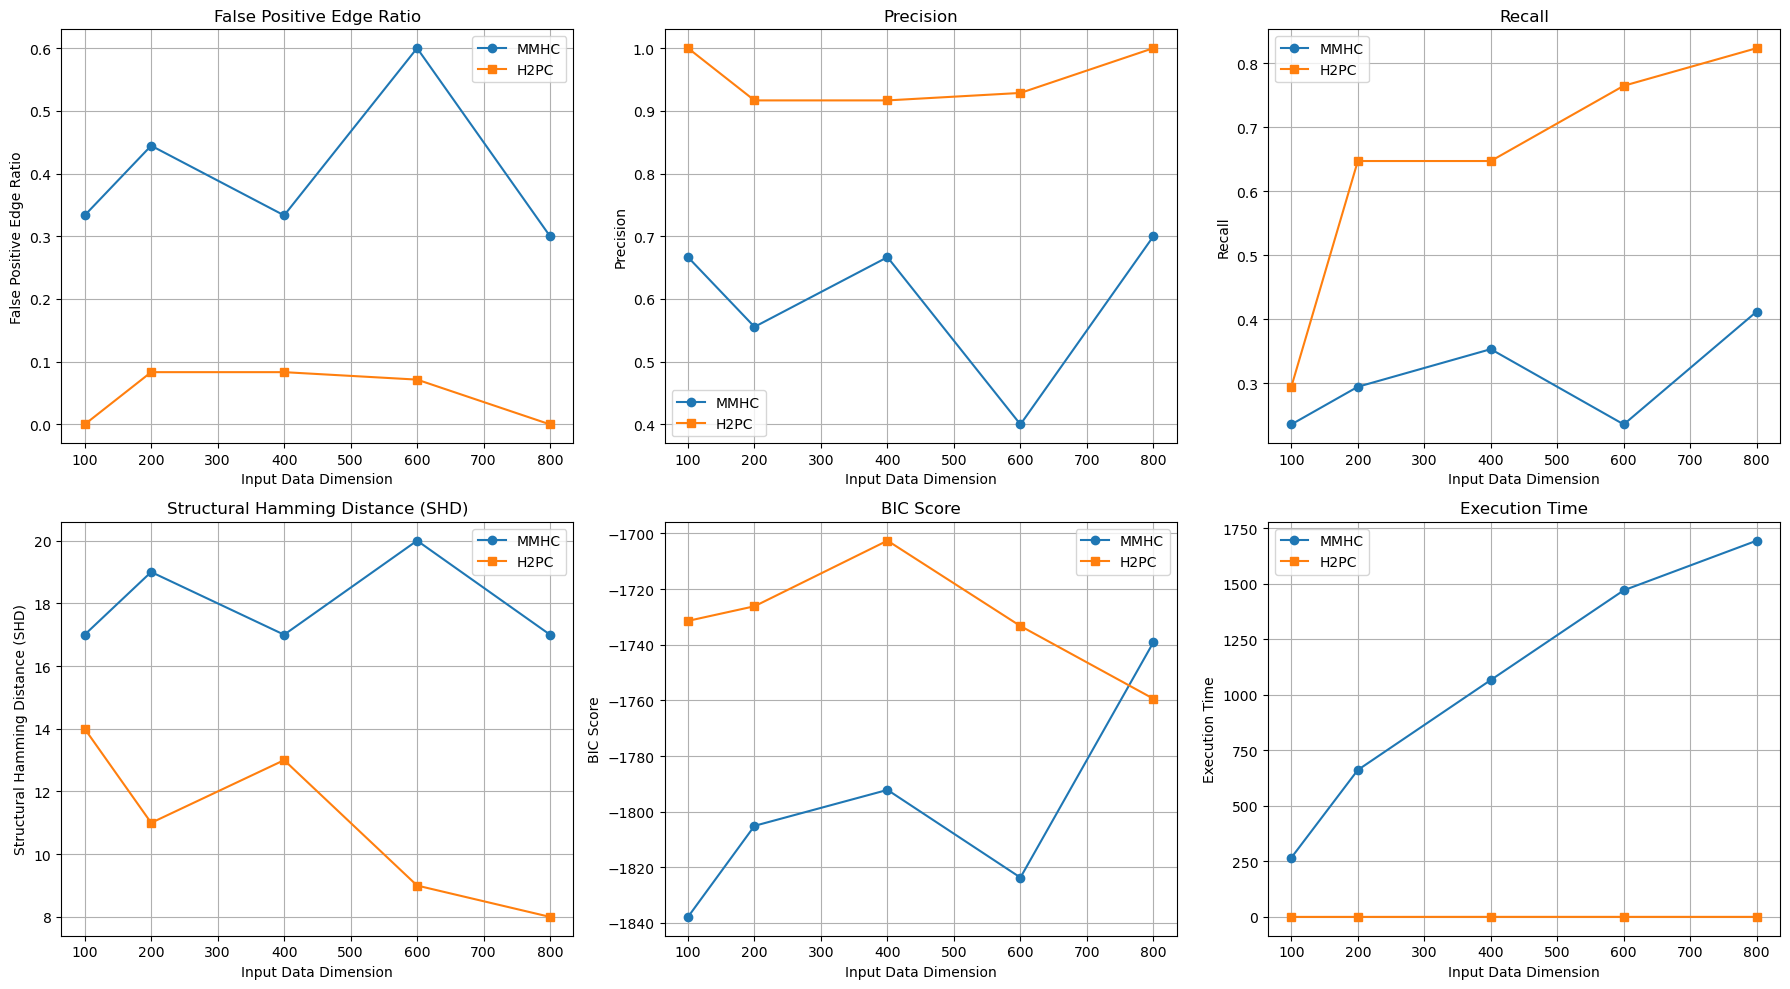

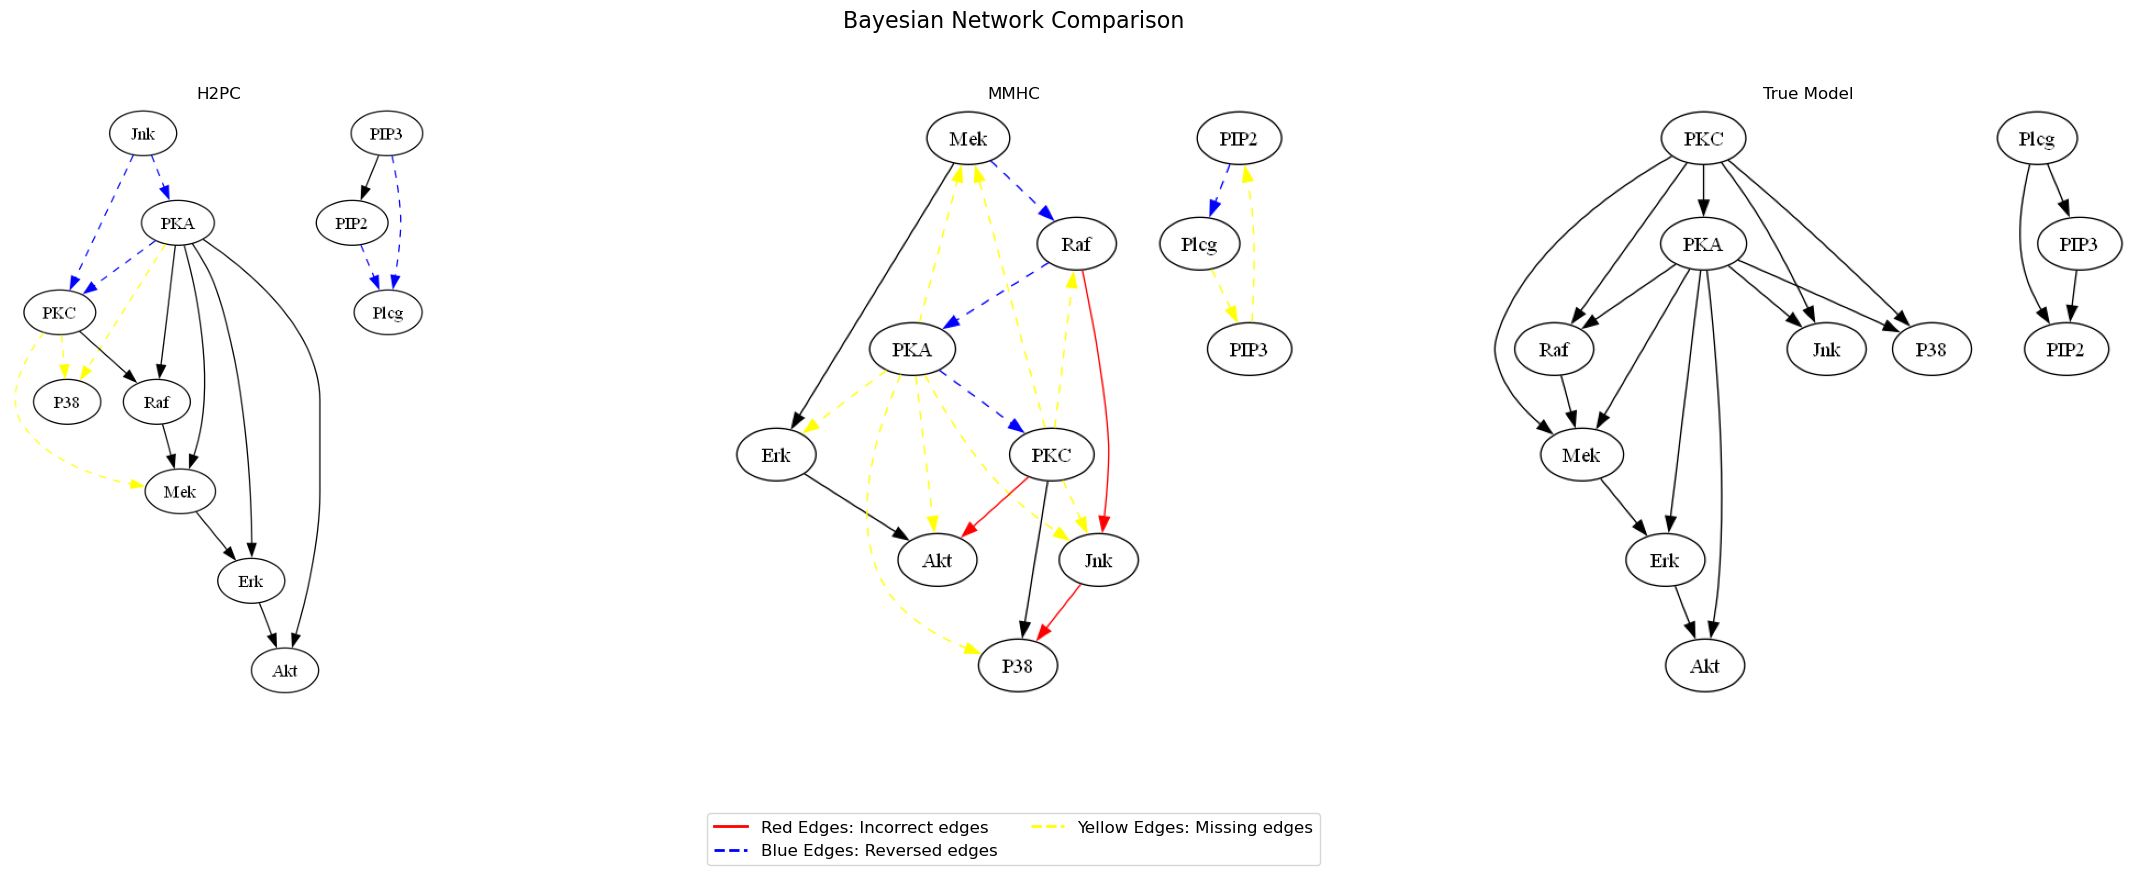

In [15]:
df = pd.read_csv("Datasets/sachs.csv")
df = df.replace({'LOW': 0, 'AVG': 1,'HIGH': 2})
sizes = [100,200,400,600,800]
df,test_data=train_test_split(df, train_size=0.8,random_state=42)
models_MMHC,models_H2PC,times_MMHC,times_H2PC=build_models(df,sizes)
metrics2,true_model=evaluate_Models(models_MMHC,models_H2PC,times_MMHC,times_H2PC,test_data,sizes,"Datasets/sachs.bif")
utils.visualize_and_compare_models(models_H2PC[-1],models_MMHC[-1],true_model,"BNs/sachs_H2PC.png","BNs/sachs_MMHC.png","BNs/sachs_true.png")

## 3. Test on Alarm Dataset

#### MMHC overflowed, the test has been runned only on H2PC algorithm.

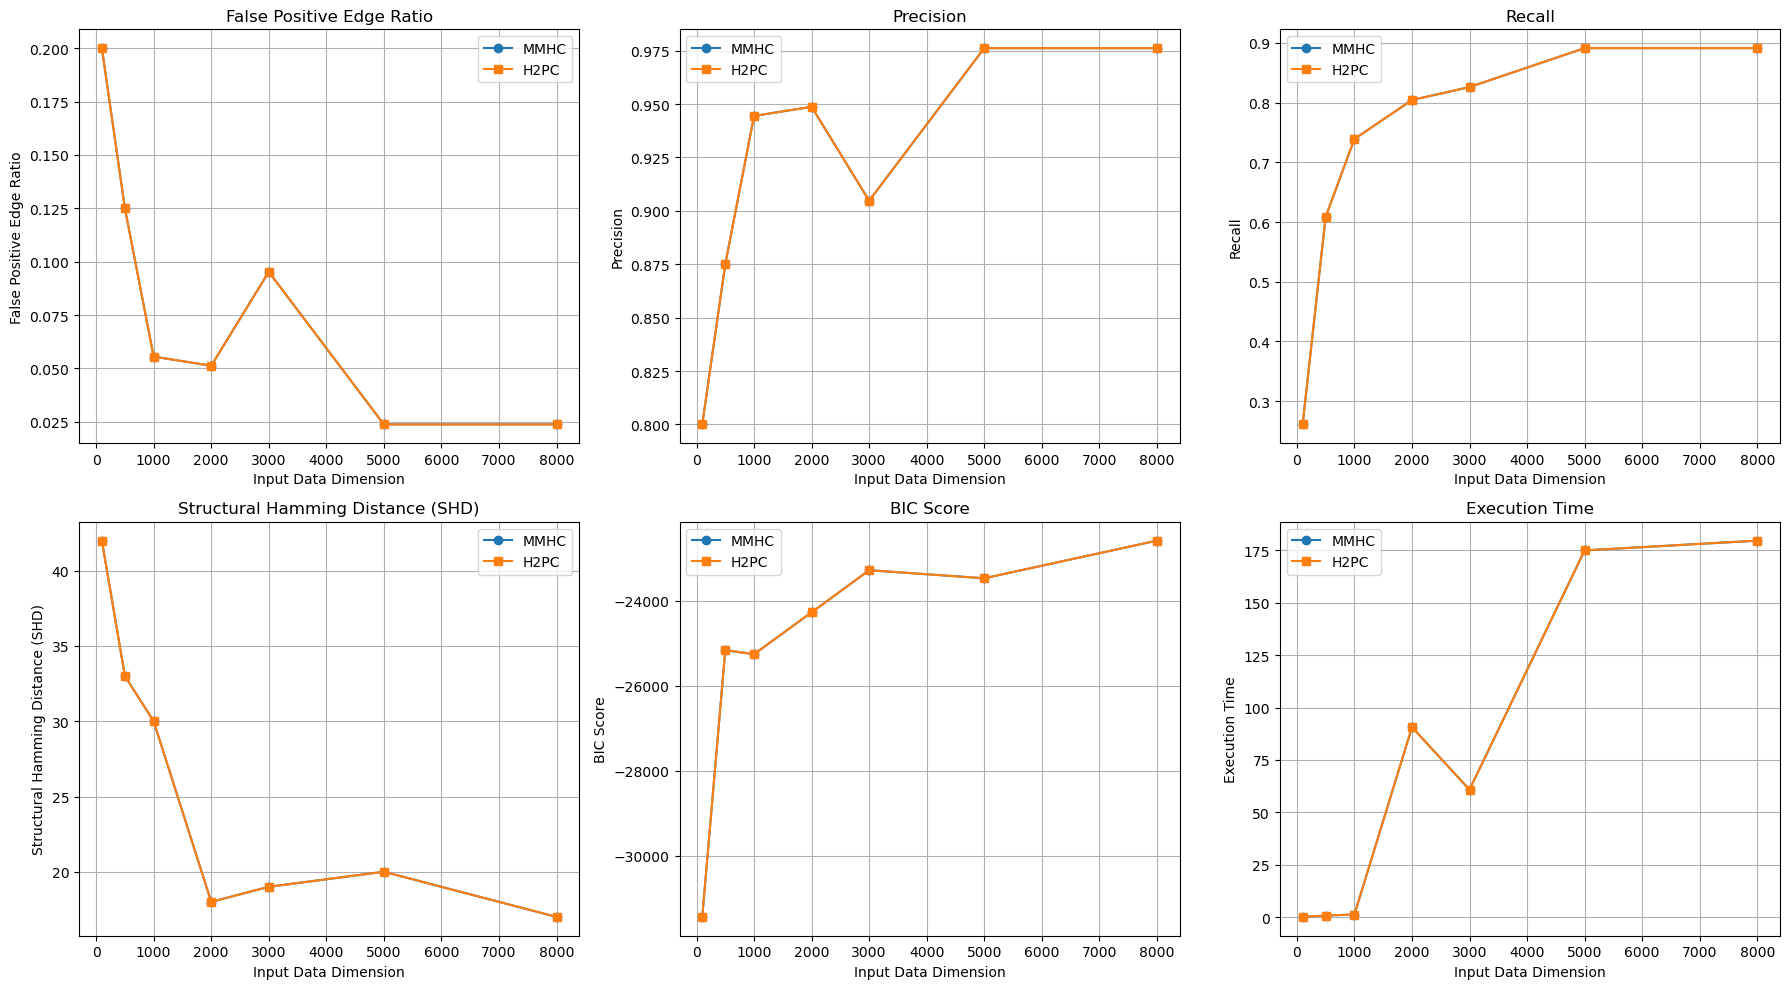

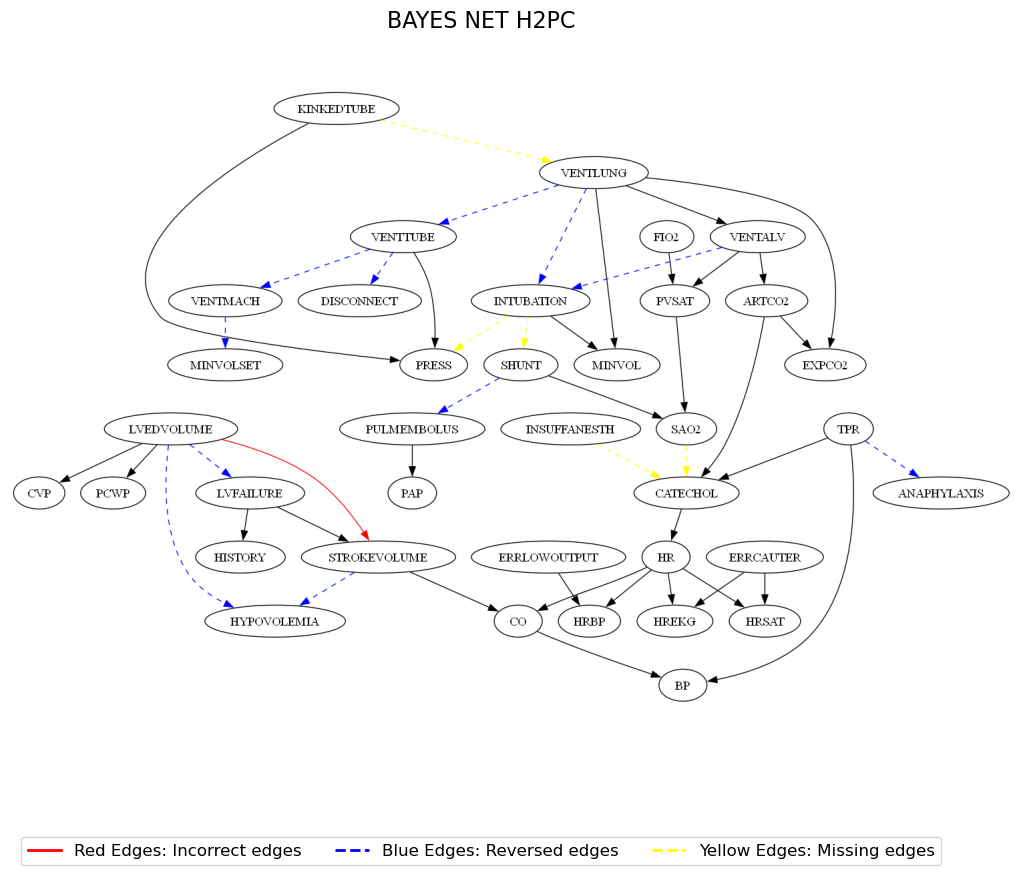

In [11]:
df = pd.read_csv("Datasets/alarm.csv")
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

sizes = [100,500,1000,2000,3000,5000,8000]
df,test_data=train_test_split(df, train_size=0.8,random_state=42)
#code runned commenting MMMHC part on the upper code (only H2PC) (MMHC takes too long to compute)
models_MMHC,models_H2PC,times_MMHC,times_H2PC=build_models(df,sizes)
true_model_bif = "Datasets/alarm.bif"
reader = BIFReader(true_model_bif)
true_model = reader.get_model()
#function runned exclusively on H2PC (MMHC takes too long to compute)
metrics3,true_model=evaluate_Models(models_H2PC,models_H2PC,times_H2PC,times_H2PC,test_data,sizes,true_model_bif)
utils.visualize_model(models_H2PC[-1],true_model.edges,"BNs/alarm_H2PC.png")
fig, axes = plt.subplots(1, 1, figsize=(24, 8))
fig.suptitle("BAYES NET H2PC", fontsize=16)
img_h2pc = Image.open("BNs/alarm_H2PC.png")
imshow_h2pc = axes.imshow(img_h2pc)
fig.legend(
        handles=[
            plt.Line2D([0], [0], color='red', lw=2, label='Red Edges: Incorrect edges'),
            plt.Line2D([0], [0], color='blue', lw=2, linestyle='dashed', label='Blue Edges: Reversed edges'),
            plt.Line2D([0], [0], color='yellow', lw=2, linestyle='dashed', label='Yellow Edges: Missing edges')
        ],
        loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, -0.1)
    )
plt.axis('off')
plt.show()

## Results commented and future possible experiments
From the above tests, the H2PC algorithm obtain extremely accurate results with a very low false positive edge ratio, time computation grows linear with dataset complexity and size.

The algorithm also worked really weel with the alarm dataset missing few edges over 46 arcs.

To improve the research, future experiments can be done:
- test the algorithm with various threshold to analyze the impact on accuracy and overall performance
- try implementing parallelization to spped up the computational process